---
# Setup

### Imports

In [1]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
from typing import Dict, Optional, Tuple
import numpy as np
from tqdm import tqdm
from copy import deepcopy

# Jax Imports
import jax
from jax import numpy as jnp
from jax.example_libraries.optimizers import adam

# Rockpool Imports
from rockpool.nn.modules import LinearJax, TimedModuleWrapper
from rockpool.nn.modules.jax.jax_lif_ode import LIFJax, LIFODEJax
from rockpool.nn.combinators import Sequential
from rockpool.timeseries import TSContinuous, TSEvent
from rockpool.parameters import Constant, SimulationParameter
from rockpool.nn.modules.jax.jax_module import JaxModule
import rockpool.training.jax_loss as l
from rockpool.devices.dynapse.utils.figure import (
    Figure
)

from rockpool.devices.dynapse.adexplif_jax import DynapSEAdExpLIFJax

from rockpool.devices.dynapse.fpga_jax import DynapSEFPGA

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100

Could not import package: 'numba' backend not found. Modules that rely on numba will not be available.
Could not import package: 'numba' backend not found. Modules that rely on numba will not be available.
Could not import package: No module named 'iaf_nest'


### Utilities

In [2]:
# @title Data Generation { display-mode: "form" }

def poisson_spike_train(
    duration: float, rate: float, dt: float, seed: Optional[int] = None
) -> np.ndarray:
    """
    random_spike_train generates a Poisson frozen random spike train 

    :param duration: simulation duration in seconds
    :type duration: float
    :param rate: expected mean spiking rate in Hertz(1/s)
    :type rate: float
    :param dt: time step length
    :type dt: float, optional
    :raises ValueError: no spike generated due to low firing rate or very short simulation time]
    :return: randomly generated discrete spike train
    :rtype: np.ndarray
    """
    np.random.seed(seed)
    steps = int(np.round(duration / dt))
    raster = np.random.poisson(rate * dt, (steps, 1))

    # Check if raster has at least one spike
    if not any(raster.flatten()):
        raise ValueError(
            "No spike generated at all due to low firing rate or short simulation time duration!"
        )

    spike_tensor = np.array(raster, dtype=np.float)
    return spike_tensor


In [3]:
dt = 1e-3

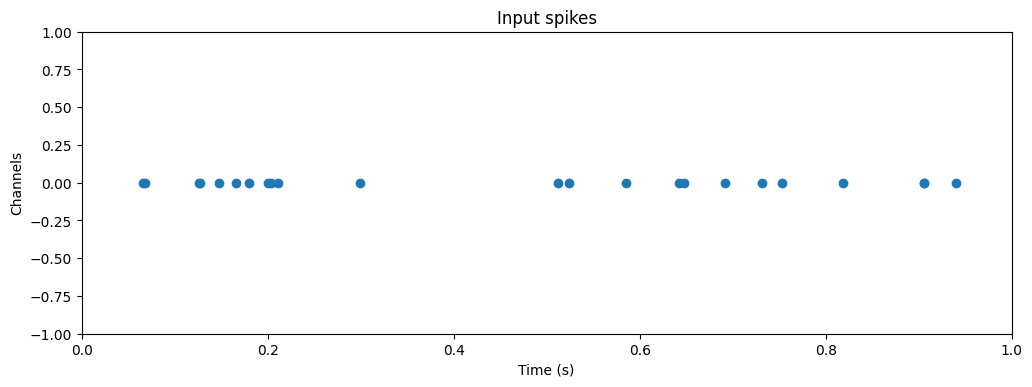

In [4]:
spikes_in = poisson_spike_train(duration=1.0, rate=20.0, dt=dt, seed=2022)
spike_ts = TSEvent.from_raster(spikes_in, name = 'Input spikes', periodic = True, dt = dt)
spike_ts.plot()

## Model Implementation

In [5]:
# --- Input Layer --- #
linear = LinearJax(
    shape=(1, 4),
    weight=jnp.array([[[0.00, 0.00, 0.00, 1e-6]]]),
    has_bias=False,
)
linear

LinearJax  with shape (1, 4)

In [6]:
# --- LIF Layer --- #
dt = 1e-3
Vth = Constant(1.0)

lif = DynapSEAdExpLIFJax(
    shape=(4, 1),
    spiking_input =True,
    dt=dt,
)


In [7]:
# --- Readout Layer --- #
# readout = RateReadout(shape=(1, 1), dt=dt)

# --- Model --- #
model = Sequential(linear, lif)
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 4)
    DynapSEAdExpLIFJax '1_DynapSEAdExpLIFJax' with shape (4, 1)
}

Now let's run the model and record the state changes over time

In [8]:
# Run!
model.reset_state()
rate_out, state, record_dict = model(spikes_in, record = True)

In [9]:
record_dict.keys()
rd = record_dict["1_DynapSEAdExpLIFJax"]

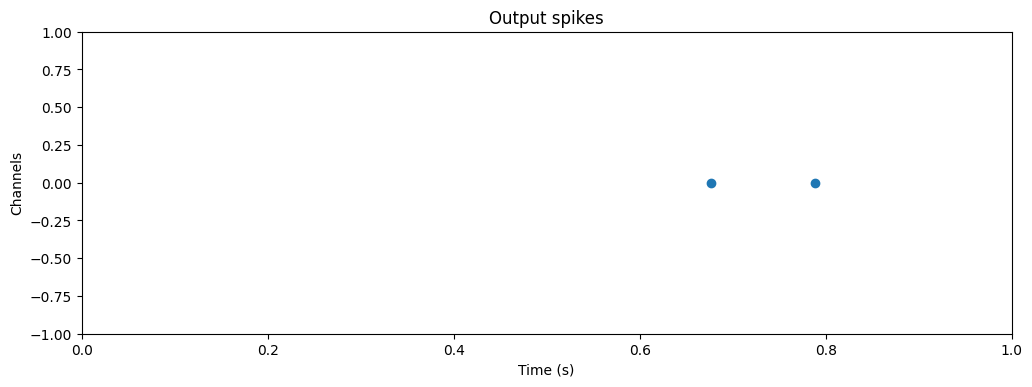

In [10]:
spike_ts_out = TSEvent.from_raster(rate_out, name = 'Output spikes', periodic = True, dt = dt)
spike_ts_out.plot()

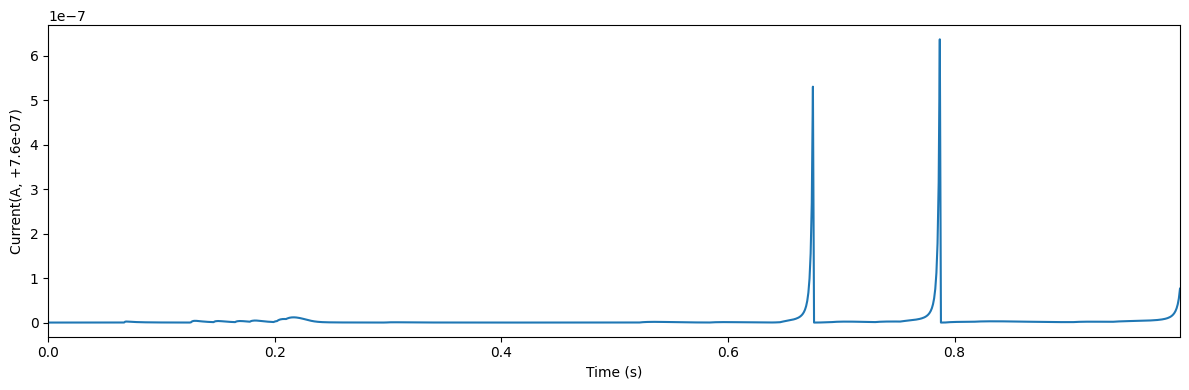

In [11]:
Figure.plot_Ix(rd["Imem"][:,0]);
# plt.yscale('log')

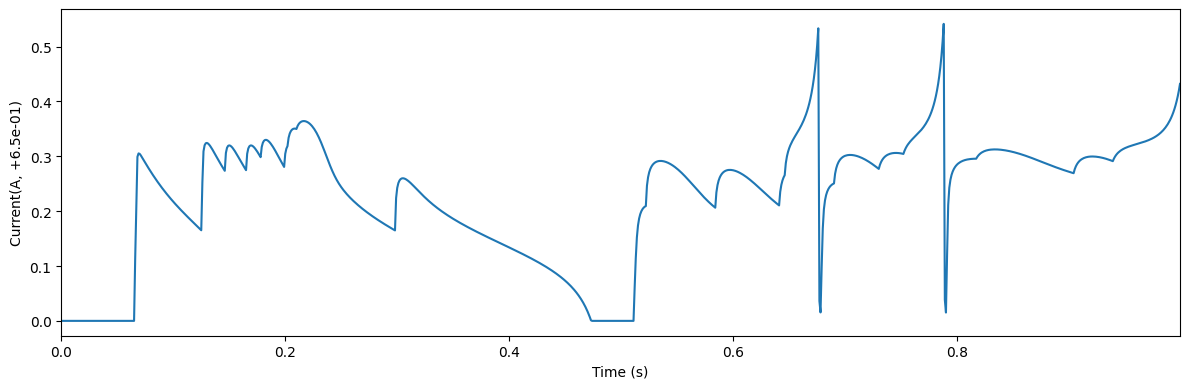

In [12]:
Figure.plot_Ix(rd["Vmem"][:,0]);

---
## Section 3: Define the Optimization Task

We want the neuron to fire at 50 Hz given the 200 Hz input. In order to arrive at this target firing rate, we need to define a loss function, such that minimising the loss will lead to our desired output rate.

### Section 3.1 : Target

Here we define the target firing rate.

In [13]:
target = 5.0

### Section 3.2 : Loss Function

We use Mean squared error (MSE), which is one of the most commonly used loss function for regression tasks in machine learning. The loss is given by the mean of the squared differences between true and predicted values for the rate of the neuron.

MSE Loss : $ l = (r - \hat{r})^ 2 $

In [14]:
# - Import the convenience functions
from rockpool.training.jax_loss import bounds_cost, make_bounds

params = {
    '0_LinearJax': model.parameters()['0_LinearJax'],
    '1_DynapSEAdExpLIFJax': {}
    }

# - Generate a set of pre-configured bounds
lower_bounds, upper_bounds = make_bounds(params)
print('lower_bounds: ', lower_bounds,
      'upper_bounds: ', upper_bounds)

lower_bounds:  {'0_LinearJax': {'weight': -inf}, '1_DynapSEAdExpLIFJax': {}} upper_bounds:  {'0_LinearJax': {'weight': inf}, '1_DynapSEAdExpLIFJax': {}}


In [15]:
lower_bounds['0_LinearJax']['weight'] = 5e-12

In [16]:
print('lower_bounds: ', lower_bounds,
      'upper_bounds: ', upper_bounds)

lower_bounds:  {'0_LinearJax': {'weight': 5e-12}, '1_DynapSEAdExpLIFJax': {}} upper_bounds:  {'0_LinearJax': {'weight': inf}, '1_DynapSEAdExpLIFJax': {}}


In [17]:
def loss_mse(parameters, net, inputs, target):
    # - Handle the network state — randomise or reset
    # print("\t Reset State:")
    net = net.reset_state()

    # print("\t Set Attributes:")
    # - Assign the provided parameters to the network
    net = net.set_attributes(parameters)
    
    # print("\t Evolve:")
    # - Evolve the network to get the ouput
    output, _, _ = net(inputs)

    rate_out = output.sum()

    # print("\t Done!")
    # - Compute a loss value w.r.t. the target output
    bounds = bounds_cost(parameters, lower_bounds, upper_bounds) * 1e3

    # print("\t Done!")
    # - Compute a loss value w.r.t. the target output
    return l.mse(rate_out, target) + bounds

In [18]:
model.parameters()

{'0_LinearJax': {'weight': array([[0.e+00, 0.e+00, 0.e+00, 1.e-06]], dtype=float32)},
 '1_DynapSEAdExpLIFJax': {'w_rec': DeviceArray([[[0.e+00, 0.e+00, 4.e-06, 0.e+00]]], dtype=float32),
  'Itau_syn': DeviceArray([[8.8652479e-12, 8.6879434e-11, 8.8652479e-12, 8.6879434e-11]],            dtype=float32),
  'f_gain_syn': DeviceArray([[4., 4., 4., 4.]], dtype=float32),
  'Itau_ahp': DeviceArray([2.8368795e-11], dtype=float32),
  'f_gain_ahp': DeviceArray([4.], dtype=float32),
  'Iw_ahp': DeviceArray([1.e-06], dtype=float32),
  'Iw_0': DeviceArray([1.e-06], dtype=float32),
  'Iw_1': DeviceArray([2.e-06], dtype=float32),
  'Iw_2': DeviceArray([4.e-06], dtype=float32),
  'Iw_3': DeviceArray([8.e-06], dtype=float32),
  'Itau_mem': DeviceArray([5.3191488e-12], dtype=float32),
  'Itau2_mem': DeviceArray([2.4e-05], dtype=float32),
  'f_gain_mem': DeviceArray([2.], dtype=float32),
  'Idc': DeviceArray([5.e-13], dtype=float32),
  'If_nmda': DeviceArray([5.e-13], dtype=float32),
  'Iref': DeviceArra

In [19]:
# _loss_trace = []
# _grad_trace = []

# loss_vgf = jax.value_and_grad(loss_mse)
# # loss_vgf = jax.value_and_grad(loss_mse)

# W = np.logspace(-7, -5, 100, dtype=np.float32)

# # Sweep over the weights
# pbar = tqdm(W)
# for w in pbar:
#      # Redefine the model with a different input weight
#      linear = LinearJax(
#           shape=(1, 4),
#           weight=jnp.array([[[0.00, 0.00, 0.00, w]]]),
#           has_bias=False,
#      )
#      lif = DynapSEAdExpLIFJax(
#           shape=(4, 1),
#           spiking_input =True,
#           dt=dt,
#      )
#      model = Sequential(linear, lif)
#      params = {
#           '0_LinearJax': model.parameters()['0_LinearJax'],
#           '1_DynapSEAdExpLIFJax': {}}

#      # - Get the loss value and gradients for this iteration
#      loss_val, grads = loss_vgf(params, model, spikes_in, target)

#      _loss = loss_val.item()
#      _loss_trace.append(_loss)
#      _grad = grads["0_LinearJax"]["weight"][:,3].item()
#      _grad_trace.append(_grad)
#      pbar.set_description(f"Loss = {_loss},  Grad = {_grad}, Weight = {w} ")

In [20]:
# surrogate_loss = np.cumsum(np.array(_grad_trace))/dt
# surrogate_loss = surrogate_loss - np.min(surrogate_loss) + np.min(_loss_trace)

# plt.figure()
# plt.plot(W, _loss_trace, label = "Actual Loss")
# # plt.plot(W, surrogate_loss, label = "Approximate Loss")
# plt.xlabel("Input Weight")
# plt.ylabel("Loss")
# plt.legend();
# plt.xscale("log")
# plt.yscale("log")

---
## Section 4 : Training a Spiking Neural Network

So far we have explored spiking rockpool modules and now we're ready to optimize our network. Let's first re-initialize the linear layer.

In [21]:
# Reinitialize the weight matrix

# TODO : Change the weight to see what happens
# TODO : What happens if we initialize the input weights very close to 0?


linear = LinearJax(
    shape=(1, 4),
    weight=jnp.array([[[0.00, 0.00, 0.00, 1e-6]]]),
    has_bias=False,
)
lif = DynapSEAdExpLIFJax(
    shape=(4, 1),
    spiking_input =True,
    dt=dt,
)
model = Sequential(linear, lif)
params = {
    '0_LinearJax': model.parameters()['0_LinearJax'],
    '1_DynapSEAdExpLIFJax': {}}

### Section 4.1 : Training Loop

We are using the MSE loss and the Adam optimizer for training. The workflow is similar to the native `torch` API.

In [22]:
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 4)
    DynapSEAdExpLIFJax '1_DynapSEAdExpLIFJax' with shape (4, 1)
}

In [23]:
# - Initialise the optimiser with the initial parameters
# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-7)
params = deepcopy(params)
opt_state = init_fun(params)

# - Get a compiled value-and-gradient function
loss_vgf = jax.value_and_grad(loss_mse)

# - Compile the optimiser update function
# update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 300

In [24]:
get_params(opt_state)

{'0_LinearJax': {'weight': array([[0.e+00, 0.e+00, 0.e+00, 1.e-05]], dtype=float32)},
 '1_DynapSEAdExpLIFJax': {}}

In [25]:
# - Loop over iterations
pbar = tqdm(range(num_epochs))
for i_trial in pbar:
    # - Get parameters for this iteration
    params = get_params(opt_state)

    # - Get the loss value and gradients for this iteration
    loss_val, grads = loss_vgf(params, model, spikes_in, target)

    # - Update the optimiser
    opt_state = update_fun(i_trial, grads, opt_state)
    # - Keep track of the loss
    

    _loss = loss_val.item()
    
    loss_t.append(loss_val.item())
    _grad = grads["0_LinearJax"]["weight"][:,3].item()
    grad_t.append(_grad)
    _p = params["0_LinearJax"]['weight']
    pbar.set_description(f"Loss = {_loss},  Grad = {_grad}, Weight = {_p}")

    if _loss == 0:
        break
    
print(loss_t[-1])

Loss = 0.0,  Grad = 0.0, Weight = [[4.6453775e-07 4.6453712e-07 4.6453783e-07 9.5676205e-06]]:   4%|▍         | 13/300 [00:12<04:31,  1.06it/s]                     

0.0


In [26]:
get_params(opt_state)

{'0_LinearJax': {'weight': DeviceArray([[4.7690980e-07, 4.7690918e-07, 4.7690986e-07, 9.5587448e-06]],            dtype=float32)},
 '1_DynapSEAdExpLIFJax': {}}

### Section 4.2 : Results

Let's check what happened during and after training. First we can see that the loss converges to zero. 

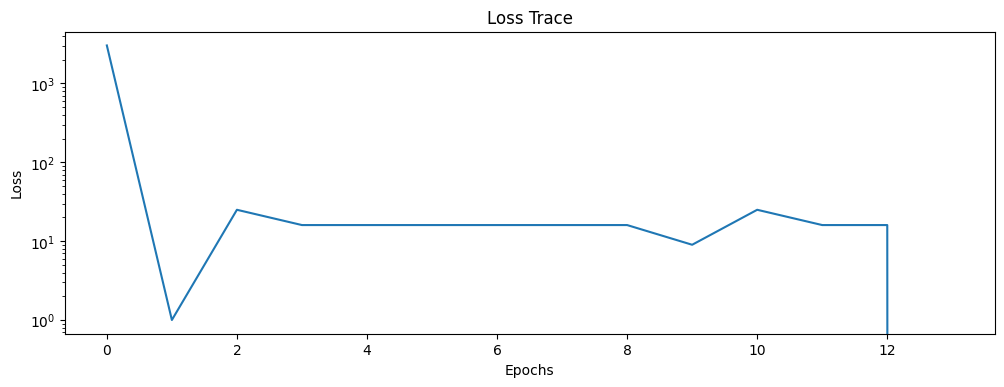

In [33]:
plt.plot(loss_t)
plt.title("Loss Trace")
plt.xlabel("Epochs")
plt.ylabel("Loss");
plt.yscale("log")

How did this happen? Inside the training loop, Adam continuously updated the weight parameter in the direction of the minimal loss.

Finally, let's run the optimized module and prove that it expresses a firing rate of 50 Hz.

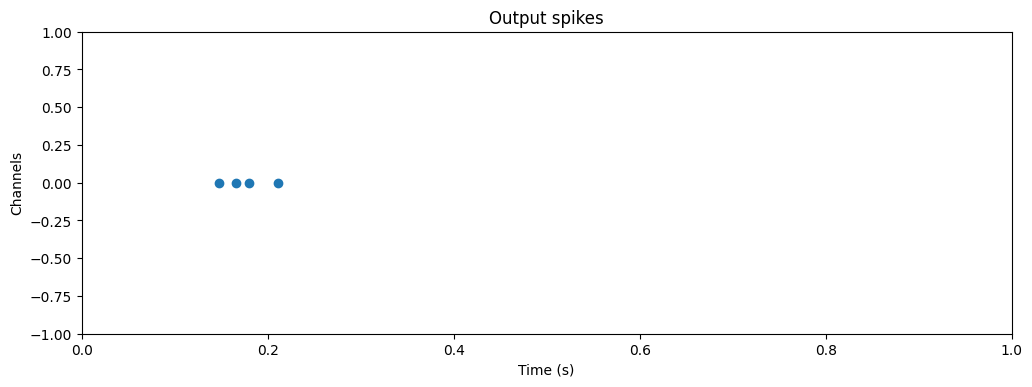

In [38]:
model = model.set_attributes(get_params(opt_state))
model.reset_state()
out, state, rec = model(spikes_in, record=True)
spike_ts_out = TSEvent.from_raster(out, name = 'Output spikes', periodic = True, dt = dt)
spike_ts_out.plot()

See that the rate reading is 50. 

In [35]:
model

JaxSequential  with shape (1, 1) {
    LinearJax '0_LinearJax' with shape (1, 4)
    DynapSEAdExpLIFJax '1_DynapSEAdExpLIFJax' with shape (4, 1)
    LinearJax '0_LinearJax' with shape (1, 4)
    DynapSEAdExpLIFJax '1_DynapSEAdExpLIFJax' with shape (4, 1)
    LinearJax '0_LinearJax' with shape (1, 4)
    DynapSEAdExpLIFJax '1_DynapSEAdExpLIFJax' with shape (4, 1)
}

In [36]:
model.parameters()

{'0_LinearJax': {'weight': DeviceArray([[4.7690980e-07, 4.7690918e-07, 4.7690986e-07, 9.5587448e-06]],            dtype=float32)},
 '1_DynapSEAdExpLIFJax': {'w_rec': array([[[0.e+00, 0.e+00, 0.e+00, 8.e-06]]], dtype=float32),
  'Itau_syn': array([[8.8652479e-12, 8.6879434e-11, 8.8652479e-12, 8.6879434e-11]],
        dtype=float32),
  'f_gain_syn': array([[4., 4., 4., 4.]], dtype=float32),
  'Itau_ahp': array([2.8368795e-11], dtype=float32),
  'f_gain_ahp': array([4.], dtype=float32),
  'Iw_ahp': array([1.e-06], dtype=float32),
  'Iw_0': array([1.e-06], dtype=float32),
  'Iw_1': array([2.e-06], dtype=float32),
  'Iw_2': array([4.e-06], dtype=float32),
  'Iw_3': array([8.e-06], dtype=float32),
  'Itau_mem': array([5.3191488e-12], dtype=float32),
  'Itau2_mem': array([2.4e-05], dtype=float32),
  'f_gain_mem': array([2.], dtype=float32),
  'Idc': array([5.e-13], dtype=float32),
  'If_nmda': array([5.e-13], dtype=float32),
  'Iref': array([5.25e-10], dtype=float32),
  'Ipulse': array([3.5e-

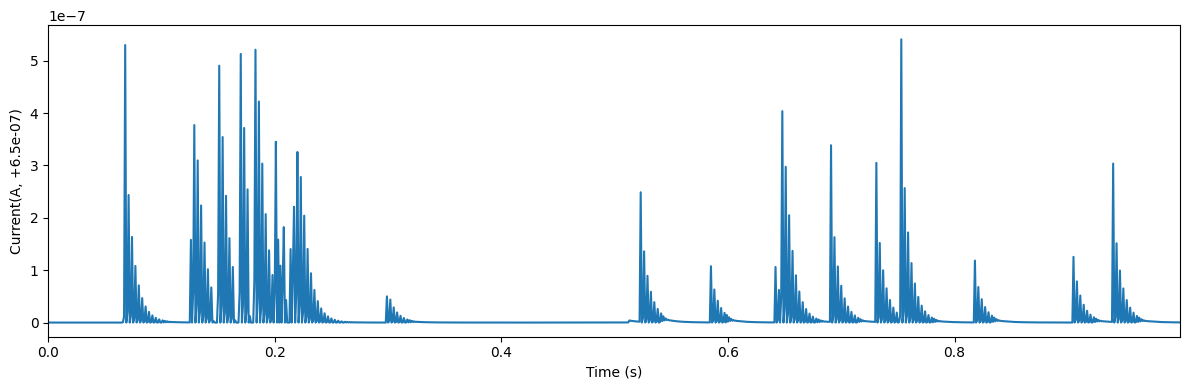

In [37]:
rd = rec["1_DynapSEAdExpLIFJax"]
Figure.plot_Ix(rd["Imem"][:,0]);

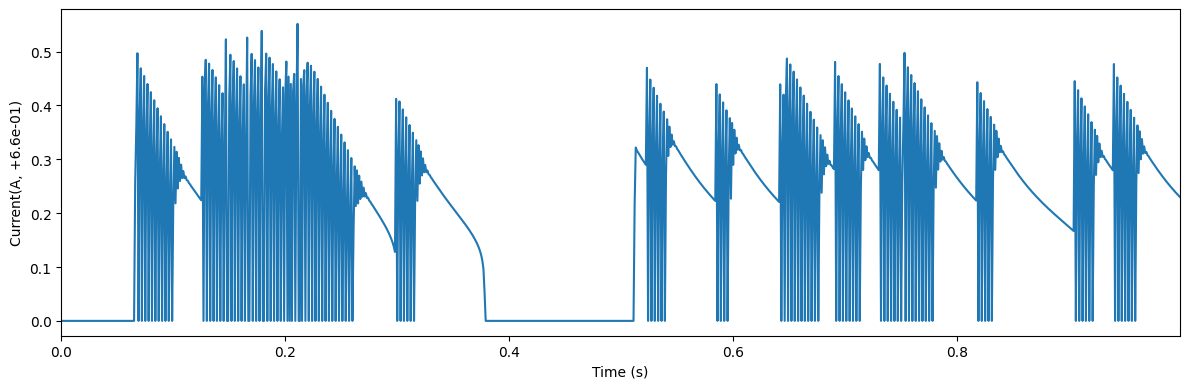

In [32]:
Figure.plot_Ix(rd["Vmem"][:,0]);

In [59]:
params = {'0_LinearJax': {'weight': jnp.array([[0,0,0, 3e-06]])},
 '1_DynapSEAdExpLIFJax': {}}
model = model.set_attributes(params)

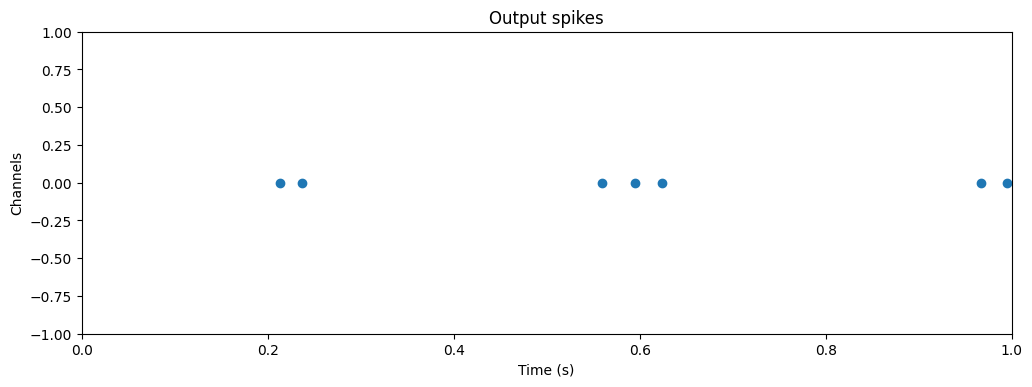

In [60]:
model.reset_state()
out, state, rec = model(spikes_in, record=True)
spike_ts_out = TSEvent.from_raster(out, name = 'Output spikes', periodic = True, dt = dt)
spike_ts_out.plot()

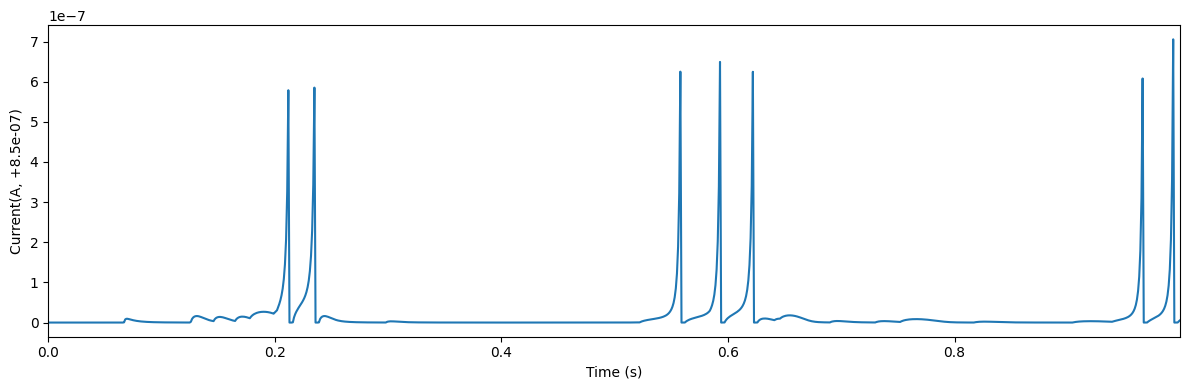

In [61]:
rd = rec["1_DynapSEAdExpLIFJax"]
Figure.plot_Ix(rd["Imem"][:,0]);

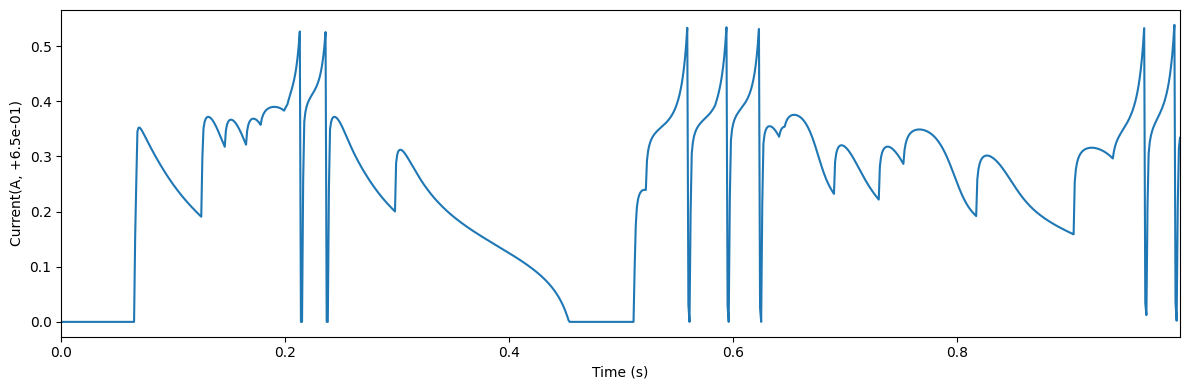

In [62]:
Figure.plot_Ix(rd["Vmem"][:,0]);